In [29]:
# Import necessary packages
import os
import pathlib
import pandas as pd # Aggregating, data manipulation
import re # Parsing information out of file names
import rioxarray as rxr # Work with raster data
import geopandas as gpd # Work with vector data
import hvplot.pandas
from math import floor, ceil

# High-Level Project Description

In this project, you will create a habitat suitability model for Sorghastrum nutans (or a plant species of your choice), a grass native to North America. In the past 50 years, its range has moved northward. The model will be based on combining multiple data layers related to soil, topography, and climate. You will also demonstrate the coding skills covered in this class by creating a modular, reproducible workflow for the model.

## Sorghastrum nutans (Yellow Indian Grass)
 Yellow indian grass is a tall, bunching sod-former, 3-8 ft. in height, with broad blue-green blades and a large, plume-like, soft, golden-brown seed head. This showy perennial’s fall color is deep orange to purple.

This is a beautiful grass with a somewhat metallic golden sheen to its flowering parts. It is an important associate in the tallgrass prairies and is relished by livestock. It appears to be favored by occasional flooding and repeated burning and sometimes forms nearly pure stands in the lowlands. Warm-season grass with rich gold-and-purple sprays of flowers and seeds in the fall. (Ontario Native Plants 2002) 

### Distribution
USA: AL , AR , AZ , CO , CT , DC , DE , FL , GA , IA , IL , IN , KS , KY , LA , MA , MD , ME , MI , MN , MO , MS , NC , ND , NE , NH , NJ , NM , NY , OH , OK , PA , RI , SC , SD , TN , TX , UT , VA , VT , WI , WV , WY
Canada: MB , NB , ON , QC , SK
Native Distribution: Que. & ME to Man., s. to FL & AZ, then south to Chiapas in southern Mexico
Native Habitat: Prairies; open woods; fields; dry slopes. Frequent in north central Texas, Edwards Plateau, and Plains Country. Sand, loam, clay, limestone; seasonal poor drainage okay.

### Growing Conditions
Water Use: Medium
Light Requirement: Sun , Part Shade , Shade
Soil Moisture: Dry , Moist
CaCO3 Tolerance: High
Drought Tolerance: High
Soil Description: Moist, rich soils. Calcareous, Sandy Sandy Loam, Medium Loam, Clay Loam, Clay, Limestone-based
Conditions Comments: Along with little bluestem, big bluestem and switchgrass, Indian grass is an important species in the tallgrass prairie. The bright yellow flowers contrast attractively with the blue-gray foliage. The grass stays low most of the year and then gets tall before blooming in early autumn. Like little bluestem, Indian grass is best planted en masse or in a wildflower meadow. 
Reference: https://www.wildflower.org/plants/result.php?id_plant=SONU2

In [5]:
# Set up a project data directory

# Step 1: Get the home folder path
home_folder = os.path.expanduser("~")

# Step 2: Define the project directory within the home folder
project_dir = os.path.join(home_folder, 'habitat_suitability' )

# Step 3: Create the project directory if it doesn't already exist
os.makedirs(project_dir, exist_ok=True)

# Step 4: Confirm creation
print(f"Project directory created at: {project_dir}")

os.makedirs(project_dir, exist_ok=True)

Project directory created at: /Users/erinzimmerman/habitat_suitability


In [17]:
# Define your study area

# * Download the USFS National Grassland Units
# * Select your study sites

# Set up the USFS National Grassland Units boundary URL
habitat_url = (
    "https://data.fs.usda.gov"
    "/geodata/edw/edw_resources/shp/"
    "S_USA.NationalGrassland.zip"
)

# Set up a path to save the data on your machine
habitat_dir = os.path.join(project_dir, 'usfs_grassland')

# Make the USFS National Grassland Units directory
os.makedirs(habitat_dir, exist_ok=True)

# Join USFS National Grassland Units shapefile path
habitat_path = os.path.join(habitat_dir, 'usfs_grassland.shp')

# Only download once
if not os.path.exists(habitat_path):
    habitat_gdf = gpd.read_file(habitat_url)
    habitat_gdf.to_file(habitat_path)

# Load from file
habitat_gdf = gpd.read_file(habitat_path)

In [22]:
habitat_gdf.head(10)
                 

,NATIONALGR,GRASSLANDN,GIS_ACRES,SHAPE_AREA,SHAPE_LEN,geometry
3,295509010328,Sheyenne National Grassland,70428.175,0.033356,4.097398,"MULTIPOLYGON (((-97.31081 46.51457, -97.30559 ..."


# A Note on the Data
A [National Grassland unit](https://data.fs.usda.gov/geodata/edw/edw_resources/shp/S_USA.NationalGrassland.zip) designated by the Secretary of Agriculture and permanently held by the Department of Agriculture under Title III of the Bankhead-Jones Farm Tenant Act.
This data is intended for read-only use. These data were prepared to describe Forest Service administrative area boundaries. The purpose of the data is to provide display, identification, and analysis tools for determining current boundary information for Forest Service managers, GIS Specialists, and others.

# Study Area

Sheyenne National Grassland is located in southeastern North Dakota, comprising 70,180 acres (28,400 ha) of public land amid 64,769 acres (26,211 ha) of privately owned land.  It is characterized by sandy soils, originally deposited as the delta of an ancient river as it emptied into glacial Lake Agassiz.  Since that time, wind and rain have shaped the topography into a unique landscape ranging from flat deltaic plains to choppy sand dunes.

It is the only National Grassland in the tallgrass prairie region of the United States.  

In [ ]:
# Download from the URL
# Define a path to save the study area
# Only download once
if not os.path.exists(study_area_path):
    # Download study area

    # Save the study area

# Load the study area

# Plot to check that the data is as expected

In [21]:
# select data from Sheyenne National Grassland only
habitat_gdf = habitat_gdf[habitat_gdf.GRASSLANDN=='Sheyenne National Grassland']
habitat_gdf.dissolve().hvplot(
    geo=True, tiles='EsriImagery',
    title='Sheyenne National Grassland',
    fill_color=None, line_color='red', line_width=3,
    frame_width=600
)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [ ]:
# Select the study sites

# Make two site maps

# Soil Data 
Soil data was drawn from the POLARIS Database hosted at Duke University. 

## Method
Soil Ph was selected as the first variable and moisture for the second. The mean of each was used as it is most representative of the 'average' found within each area of interest.

Samples from a soil depth of XX were selected as that is the center of the root depth of Sorghastrum nutans. In general, this species is robust and found in a diversity of soil types. 

In [24]:

# Define the download URL for the study area (Polaris Data)
soil_url = ("http://hydrology.cee.duke.edu"
            "/POLARIS/PROPERTIES/v1.0"
            "/ph"
            "/mean"
            "/30_60/"
            "lat4647_lon-97-96.tif"
)

soil_url

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/ph/mean/30_60/lat4647_lon-97-96.tif'

In [28]:
habitat_gdf.total_bounds

array([-97.46880119,  46.09533528, -96.93853933,  46.57203363])

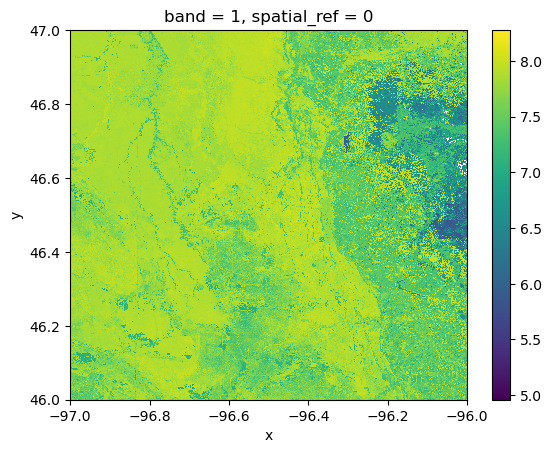

In [27]:
soil_da = rxr.open_rasterio(
    soil_url,
    mask_and_scale=True
).squeeze()

soil_da
soil_da.plot()

In [ ]:
hls_dir = os.path.join (
    project_dir,
    'hls'
)

if not os.path.exists(hls_dir):
    # Download sample raster data
    response = requests.get(hls_URL)

    # Save the raster data (uncompressed)
    with zipfile.ZipFile(BytesIO(response.content)) as hls_zip:
        hls_zip.extractall(hls_dir)

# Load in soil data

hls_URL = ("https://github.com/cu-esiil-edu/esiil-learning-portal"
    "/releases/download/data-release/"
    "redlining-foundations-data.zip"
)

hls_dir = os.path.join (
    project_dir,
    'hls'
)

if not os.path.exists(hls_dir):
    # Download sample raster data
    response = requests.get(hls_URL)

    # Save the raster data (uncompressed)
    with zipfile.ZipFile(BytesIO(response.content)) as hls_zip:
        hls_zip.extractall(hls_dir)
For each grassland:
  * Download model variable as raster layers covering your study area envelope, including at least one soil variable from the POLAris dataset.

In [ ]:
# Define download URL template for the soil data

# Prepare URL and file path for download
soil_url = (
    "https://github.com/cu-esiil-edu/esiil-learning-portal/releases"
    "/download/data-release/redlining-foundations-data.zip"
)
soil1_dir = os.path.join(project_dir, 'hls')

if not glob(os.path.join(soil1_dir, '*.tif')):
    # Download sample raster data
    soil1_response = requests.get(soil1_url)

    # Save the raster data (uncompressed)
    with zipfile.ZipFile(BytesIO(soil1_response.content)) as soil1_zip:
        soil1_zip.extractall(soil1_dir)

# List out all soil files needed for download

output_da_list = [  ]

# Loop through each of the soil files (more info in redlining 92)

    # Download raster data

    # Extract metadata from the file name
        # Compile a regular expression to search for metadata
        uri_re = re.compile(
            r"HLS\.L30\.(?P<tile_id>T[0-9A-Z]+)\.(?P<date>\d+)T\d+\.v2\.0\.(?P<band_id>.+)\.tif"
        )
        # Find all the metadata in the file name
        uri_groups = [
        uri_re.search(denver_file.full_name).groupdict()
        for denver_file in denver_files]
    

    # Unzip the raster data

    # Only download once -- Save raster data to the disk

    # Load the raster data into Python, mask, and scale.

    def process_image(uri, bounds_gdf):
    """
    Load, crop, and scale a raster image from earthaccess

    Parameters
    ----------
    uri: file-like or path-like
      File accessor downloaded or obtained from earthaccess
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to

    Returns
    -------
    cropped_da: rxr.DataArray
      Processed raster
    """
    # Connect to the raster image
    da = rxr.open_rasterio(uri, mask_and_scale=True).squeeze()

    # Get the total boundary
    # Make sure that the CRSs match between vector and raster data (Get the study bounds section)
    bounds = (
      bounds_gdf
      .to_crs(da.rio.crs)
      .total_bounds
)

    # Crop the raster data

    cropped_da = da.rio.clip_box(*bounds)

    return cropped_da

    process_image(denver_files[8], denver_redlining_gdf)

    

  
output_da_list.append(cropped_da)

# merge tiles

denver_merged_das = {
    band_name: merge_arrays(das) 
    for band_name, das 
    in denver_das.items()}



# Make a plot to check the download (don't need to make a cloud mask), load in multiple bands, or calcualte the spectral indices
    denver_merged_das['green'].plot(cmap='Greens', robust=True)

In [ ]:
# Merge tile

# Plot a merged raster band
denver_merged_das['green'].plot(cmap='Greens', robust=True)